In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

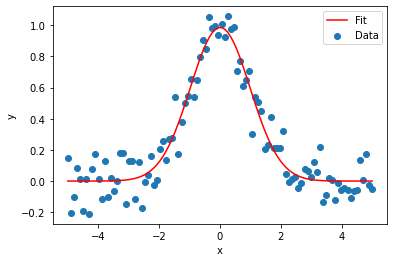

0.5783347610100934


In [5]:
#TEST DATA
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

x = np.linspace(-5, 5, 100)
y = gaussian(x, 1, 0, 1) + np.random.normal(0, 0.1, 100)

#fitting
params, _ = curve_fit(gaussian, x, y)

plt.scatter(x, y, label='Data')
plt.plot(x, gaussian(x, *params), color='red', label='Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
print(fwhm*360/(24*60))
